In [2]:
import os
import sys
# Add the src directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.data_handling.historical_data_handler import SingleSymbolDataHandler
from src.feature_engineering.feature_extractor import SingleSymbolFeatureExtractor
%cd $project_root

/Users/zhaoyub/Documents/Tradings/tradebotv3


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%load_ext autoreload

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.8f' % x)
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [5]:
datahandler = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '15m', '2023-01-01', '2024-09-24'
datahandler.load_data(inter, begin, end)
BTC_indicator = SingleSymbolFeatureExtractor('BTCUSDT', datahandler)
BTC_indicator.load_full_range()
indicators = BTC_indicator.indicators
datahandler.cleaned_data['close'] = datahandler.cleaned_data['close']
indicators = pd.concat([indicators,datahandler.cleaned_data[['close', 'volume']]],axis= 1)

In [6]:
indicators.columns

Index(['rsi', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d',
       'bollinger_mavg', 'bollinger_upper', 'bollinger_lower', 'atr', 'vwap',
       'obv', 'sma', 'ema', 'adx', 'close', 'volume'],
      dtype='object')

In [11]:
def compute_performance_metrics(trades, capital_series, indicators, initial_capital=1000):
    """
    Computes performance metrics based on the executed trades and capital evolution.
    
    Metrics include:
      - Total ROI (%)
      - Max Drawdown (%)
      - Sharpe Ratio (using period returns from the capital series)
      - Symbol ROI (%) based on the close price changes
      - Trade Efficiency (%)
      - Trade Distribution (winning and losing trades and win rate)
      - Profit Attribution (total, average, max, and min profit)
      - Risk Reward Ratio: average win / average loss (absolute)
      - Total Trades: count of completed trades (sell orders)
      - Largest Win Trade (%): best winning trade profit
      - Largest Lost Trade (%): worst trade profit
      - Sortino Ratio: risk-adjusted return using downside volatility
      
    Parameters:
        trades (list): List of trade dictionaries.
        capital_series (pd.Series): Series of capital values over time.
        indicators (pd.DataFrame): DataFrame that contains the 'close' price column.
        initial_capital (float): Starting capital.
    
    Returns:
        dict: Dictionary with performance metrics.
    """
    # Total ROI (%)
    final_capital = capital_series.iloc[-1]
    total_roi = ((final_capital - initial_capital) / initial_capital) * 100

    # Max Drawdown (%)
    running_max = capital_series.cummax()
    drawdowns = (capital_series - running_max) / running_max
    max_drawdown = abs(drawdowns.min()) * 100
    
    # Compute returns from capital series (assume equal time intervals)
    returns = capital_series.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std() if returns.std() != 0 else np.nan

    # Symbol ROI (%) based on the underlying asset's price
    initial_price = indicators['close'].iloc[0]
    final_price = indicators['close'].iloc[-1]
    symbol_roi = ((final_price - initial_price) / initial_price) * 100

    # Trade Efficiency (%) = (net profit / total absolute profit) * 100
    trade_profits = [t['profit'] for t in trades if t.get('type') == 'sell' and 'profit' in t]
    total_profit = sum(trade_profits)
    gross_profit = sum(abs(p) for p in trade_profits) if trade_profits else 0
    trade_efficiency = (total_profit / gross_profit * 100) if gross_profit != 0 else np.nan

    # Trade Distribution: count winning, losing trades and win rate.
    winning_trades = [p for p in trade_profits if p > 0]
    losing_trades = [p for p in trade_profits if p < 0]
    win_rate = (len(winning_trades) / len(trade_profits) * 100) if trade_profits else np.nan
    trade_distribution = {
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate (%)': win_rate
    }
    
    # Profit Attribution: total, average, maximum, and minimum profit per trade.
    profit_attribution = {
        'total_profit': total_profit,
        'average_profit': (total_profit / len(trade_profits)) if trade_profits else 0,
        'max_profit': max(trade_profits) if trade_profits else 0,
        'min_profit': min(trade_profits) if trade_profits else 0
    }
    
    # Additional Metrics
    # Total Trades: count of completed trades (sell orders with a profit key)
    total_trades = len([t for t in trades if t.get('type') == 'sell' and 'profit' in t])
    
    # Risk Reward Ratio: ratio of average winning trade profit to average losing trade profit (absolute)
    avg_win = np.mean([p for p in trade_profits if p > 0]) if winning_trades else np.nan
    avg_loss = np.mean([abs(p) for p in trade_profits if p < 0]) if losing_trades else np.nan
    risk_reward_ratio = (avg_win / avg_loss) if (avg_loss and avg_loss > 0) else np.nan

    # Largest Win Trade (%)
    largest_win_trade = np.max([p for p in trade_profits if p > 0]) if winning_trades else np.nan
    
    # Largest Lost Trade (%)
    largest_lost_trade = np.min([p for p in trade_profits if p < 0]) if losing_trades else np.nan

    # Sortino Ratio calculation:
    # Assuming a daily frequency; use 252 trading days for annualization.
    risk_free_rate = 0.02
    annualization_factor = 252
    target = (1 + risk_free_rate) ** (1 / annualization_factor) - 1
    downside_returns = returns[returns < target]
    downside_std = downside_returns.std() if not downside_returns.empty else 0
    sortino_ratio = (returns.mean() - target) / downside_std if downside_std > 0 else np.nan

    # Compile all metrics into one dictionary
    metrics = {
        'Total ROI (%)': total_roi,
        'Max Drawdown (%)': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Symbol ROI (%)': symbol_roi,
        'Trade Efficiency (%)': trade_efficiency,
        'Trade Distribution': trade_distribution,
        'Profit Attribution': profit_attribution,
        'Risk Reward Ratio': risk_reward_ratio,
        'Total Trades': total_trades,
        'Largest Win Trade (%)': largest_win_trade,
        'Largest Lost Trade (%)': largest_lost_trade,
        'Sortino Ratio': sortino_ratio
    }
    
    return metrics
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

def plot_price_and_capital(indicators, capital_series):
    """
    Plots both the asset's price (from indicators['close']) and the capital evolution on the same figure.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame containing at least the 'close' column for asset prices.
        capital_series (pd.Series): Series representing the evolution of capital over time.
    """
    # Ensure the capital_series index is timezone naive and normalized (date only)
    if isinstance(capital_series.index, pd.DatetimeIndex):
        if capital_series.index.tz is not None:
            capital_series.index = capital_series.index.tz_localize(None)
    else:
        capital_series.index = pd.to_datetime(capital_series.index, errors='coerce')
    capital_series.index = capital_series.index.normalize()
    
    # Also, ensure the indicators index is timezone naive and normalized
    if isinstance(indicators.index, pd.DatetimeIndex):
        if indicators.index.tz is not None:
            indicators.index = indicators.index.tz_localize(None)
    else:
        indicators.index = pd.to_datetime(indicators.index, errors='coerce')
    indicators.index = indicators.index.normalize()
    
    # Create a figure and a primary axis for capital
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    color_capital = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Capital', color=color_capital)
    ax1.plot(capital_series.index, capital_series.values, label='Capital', color=color_capital)
    ax1.tick_params(axis='y', labelcolor=color_capital)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Create a secondary axis for the price
    ax2 = ax1.twinx()
    color_price = 'tab:red'
    ax2.set_ylabel('Price', color=color_price)
    ax2.plot(indicators.index, indicators['close'], label='Price', color=color_price)
    ax2.tick_params(axis='y', labelcolor=color_price)
    
    # Improve layout and rotate dates
    fig.autofmt_xdate()
    fig.tight_layout()
    
    plt.title('Capital and Price Evolution Over Time')
    plt.grid(True)
    plt.show()

# Example usage:
# plot_price_and_capital(indicators_2, capital_series)

def plot_capital(capital_series):
    """
    Plots the evolution of capital over time with simplified date formatting.
    
    Parameters:
        capital_series (pd.Series): Capital values with a time/index.
    """
    # Check if the index is numeric (e.g., Unix epoch seconds)
    if isinstance(capital_series.index, pd.DatetimeIndex):
        if capital_series.index.tz is not None:
            capital_series.index = capital_series.index.tz_localize(None)
    else:
        # Otherwise, attempt to convert the index to datetime.
        capital_series.index = pd.to_datetime(capital_series.index, errors='coerce')
    
    # If conversion failed (NaT values), print a warning
    if capital_series.index.isnull().any():
        print("Warning: Some index values could not be converted to datetime. Check your index format.")
    
    # Normalize the dates to remove time components
    capital_series.index = capital_series.index.normalize()
    
    plt.figure(figsize=(12, 6))
    ax = plt.gca()
    capital_series.plot(ax=ax, label='Capital', color='blue')
    
    # Format the x-axis to show only the date (Year-Month-Day)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gcf().autofmt_xdate()  # Rotate date labels for clarity
    
    plt.xlabel('Time')
    plt.ylabel('Capital')
    plt.title('Capital Evolution Over Time')
    plt.grid(True)
    plt.legend()
    plt.show()

## Strategy 1: MACD_hist with threshold

In [12]:
import pandas as pd
import numpy as np

def dynamic_macd_trading_with_threshold(indicators, fee=0.001, initial_capital=1000, threshold=1):
    """
    Simulates a MACD trading strategy using full capital investment with a threshold for the MACD histogram.
    
    The strategy enters a long position when the MACD histogram (macd_diff) exceeds the threshold and exits 
    when it falls below the negative threshold. This helps reduce the number of trades by filtering out noise.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame with at least 'macd_diff' and 'close' columns.
        fee (float): Transaction fee as a fraction (default: 0.001 for 0.1% fee).
        initial_capital (float): Starting capital.
        threshold (float): The threshold for the MACD histogram to trigger trades.
                           Buy signal when macd_diff > threshold and sell signal when macd_diff < -threshold.
    
    Returns:
        trades (list): List of executed trades (each is a dict with trade details).
        capital_series (pd.Series): Series of capital values over time, using the same index as indicators.
    """
    in_position = False  # True if holding the asset
    capital = initial_capital
    position_size = 0    # Number of asset units purchased
    entry_capital = 0    # Capital allocated at entry
    trades = []          # List to record each trade
    capital_record = []  # Record capital evolution

    for i in range(len(indicators)):
        current_macd_diff = indicators['macd_diff'].iloc[i]
        current_price = indicators['close'].iloc[i]
        
        # Buy signal: not in position and MACD histogram exceeds positive threshold
        if not in_position and current_macd_diff > threshold:
            buy_price = current_price * (1 + fee)  # Fee applied increases the buying price
            position_size = capital / buy_price
            entry_capital = capital
            in_position = True
            trades.append({
                'type': 'buy',
                'price': buy_price,
                'index': indicators.index[i]
            })
        
        # Sell signal: in position and MACD histogram falls below negative threshold
        elif in_position and current_macd_diff < -threshold:
            sell_price = current_price * (1 - fee)  # Fee applied decreases the selling price
            new_capital = position_size * sell_price
            profit = new_capital - entry_capital
            capital = new_capital
            in_position = False
            trades.append({
                'type': 'sell',
                'price': sell_price,
                'index': indicators.index[i],
                'profit': profit
            })
        
        capital_record.append(capital)
    
    # If still in position at the end, close the position at the final price.
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        capital = new_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital  # Update the final capital record
    
    # Create a pandas Series for capital evolution using the same index as the indicators.
    capital_series = pd.Series(capital_record, index=indicators.index)
    
    return trades, capital_series


Performance Metrics:
Total ROI (%): -2.357248202182325
Max Drawdown (%): 39.87335593555883
Sharpe Ratio: 0.0007211234374067377
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): -0.26671786704310035
Trade Distribution: {'winning_trades': 181, 'losing_trades': 270, 'win_rate (%)': 40.133037694013304}
Profit Attribution: {'total_profit': -23.572482021823248, 'average_profit': -0.05226714417255709, 'max_profit': 134.72420911805693, 'min_profit': -57.31196166407756}
Risk Reward Ratio: 1.4837765457129013
Total Trades: 451
Largest Win Trade (%): 134.72420911805693
Largest Lost Trade (%): -57.31196166407756
Sortino Ratio: -0.07162034032748257


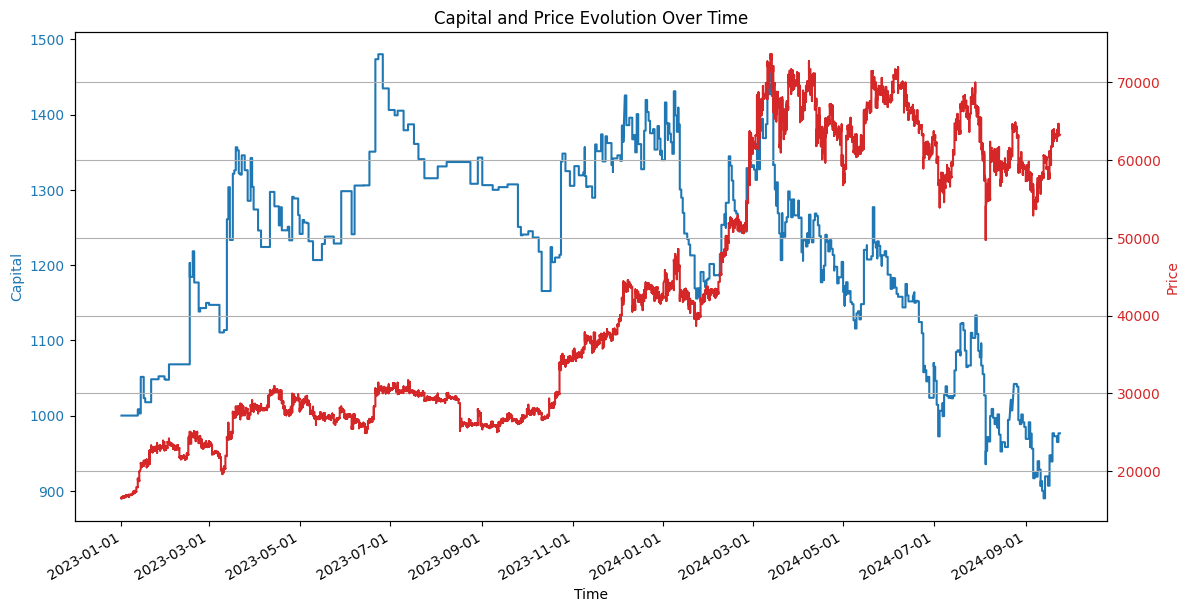

In [13]:
trades, capital_series = dynamic_macd_trading_with_threshold(indicators, threshold= 40)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)

## Strategy 2: MACD + Trend Confirmation

Performance Metrics:
Total ROI (%): 142.00145700188415
Max Drawdown (%): 28.636068837554156
Sharpe Ratio: 0.008170404219610626
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 15.834465479001858
Trade Distribution: {'winning_trades': 85, 'losing_trades': 105, 'win_rate (%)': 44.73684210526316}
Profit Attribution: {'total_profit': 1420.0145700188414, 'average_profit': 7.4737608948360075, 'max_profit': 291.7627277908862, 'min_profit': -218.4944239205288}
Risk Reward Ratio: 1.7000977257656866
Total Trades: 190
Largest Win Trade (%): 291.7627277908862
Largest Lost Trade (%): -218.4944239205288
Sortino Ratio: -0.06031735772681432


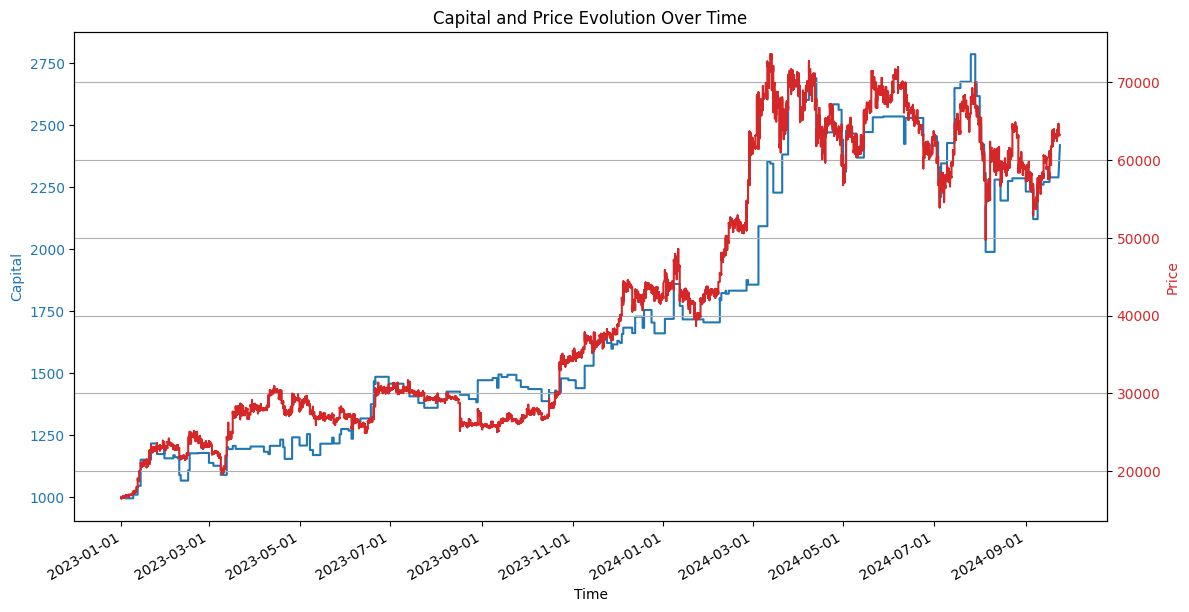

In [14]:
import pandas as pd
import numpy as np

def dynamic_macd_trading_with_trend_confirmation(
    indicators, 
    fee=0.001, 
    initial_capital=1000, 
    macd_threshold=0.0, 
    adx_threshold=25
):
    """
    Simulates an enhanced MACD trading strategy with trend confirmation.
    
    The strategy enters a long position when the MACD histogram (macd_diff) exceeds the positive threshold
    and the ADX indicates a trending market (i.e., ADX is above the specified threshold). It exits the position 
    when the MACD histogram falls below the negative threshold and ADX still confirms a trending market.
    
    This helps avoid trading during sideways or range-bound markets.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame with at least 'macd_diff', 'close', and 'adx' columns.
        fee (float): Transaction fee as a fraction (default: 0.001 for 0.1% fee).
        initial_capital (float): Starting capital.
        macd_threshold (float): The threshold for the MACD histogram to trigger trades.
                                Buy when macd_diff > macd_threshold and sell when macd_diff < -macd_threshold.
        adx_threshold (float): Minimum ADX value to consider the market trending (default: 25).
    
    Returns:
        trades (list): List of executed trades (each is a dict with trade details).
        capital_series (pd.Series): Series of capital values over time, using the same index as indicators.
    """
    in_position = False  # True if holding the asset
    capital = initial_capital
    position_size = 0    # Number of asset units purchased
    entry_capital = 0    # Capital allocated at entry
    trades = []          # List to record each trade
    capital_record = []  # Record capital evolution
    
    for i in range(len(indicators)):
        current_macd_diff = indicators['macd_diff'].iloc[i]
        current_adx = indicators['adx'].iloc[i]
        current_price = indicators['close'].iloc[i]
        
        # Confirm that market is trending before taking any position
        is_trending = current_adx >= adx_threshold
        
        # Buy signal: not in position, MACD histogram exceeds positive threshold, and market is trending.
        if not in_position and current_macd_diff > macd_threshold and is_trending:
            buy_price = current_price * (1 + fee)  # Fee increases the buying price
            position_size = capital / buy_price
            entry_capital = capital
            in_position = True
            trades.append({
                'type': 'buy',
                'price': buy_price,
                'index': indicators.index[i]
            })
        
        # Sell signal: in position, MACD histogram falls below negative threshold, and market is trending.
        elif in_position and current_macd_diff < -macd_threshold and is_trending:
            sell_price = current_price * (1 - fee)  # Fee decreases the selling price
            new_capital = position_size * sell_price
            profit = new_capital - entry_capital
            capital = new_capital
            in_position = False
            trades.append({
                'type': 'sell',
                'price': sell_price,
                'index': indicators.index[i],
                'profit': profit
            })
        
        capital_record.append(capital)
    
    # Close any remaining position at the end of the backtest
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        capital = new_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital  # Update the final capital record
    
    # Create a pandas Series for capital evolution using the same index as the indicators.
    capital_series = pd.Series(capital_record, index=indicators.index)
    
    return trades, capital_series
trades, capital_series = dynamic_macd_trading_with_trend_confirmation(indicators, macd_threshold=0,adx_threshold=45)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)

Here’s a breakdown of the MACD strategy’s performance metrics and some insights:

- **Total ROI (142%):**  
  The strategy achieves a strong overall return on investment, which suggests that, over the backtest period, it generated significant profits.

- **Max Drawdown (28.64%):**  
  A drawdown of about 28.6% is moderate but could be concerning for risk-averse investors. It indicates that, at worst, the portfolio dropped nearly 30% from a peak, so risk management might need further refinement.

- **Sharpe Ratio (≈0.008):**  
  The Sharpe ratio is extremely low, indicating that on a risk-adjusted basis, the returns are not very compelling. This could be due to high volatility or frequent small losses offsetting the gains.

- **Symbol ROI (282.88%):**  
  This figure implies that the underlying asset (or assets) performed exceptionally well, possibly contributing to the overall high ROI. However, this also means the strategy's success might be heavily dependent on the asset’s own performance rather than the trading signals.

- **Trade Efficiency (15.83%):**  
  With an efficiency of around 15.8%, the average profit per trade is relatively low compared to the total capital involved. This could indicate that many trades yield only modest gains.

- **Trade Distribution:**  
  - **Winning Trades:** 85  
  - **Losing Trades:** 105  
  - **Win Rate:** ~44.74%  
  The win rate is below 50%, meaning there are more losing trades than winning ones. However, if the winning trades are large enough to compensate for the losses, the overall ROI can still be positive.

- **Profit Attribution:**  
  - **Total Profit:** ~1420  
  - **Average Profit per Trade:** ~7.47  
  - **Maximum Profit:** ~291.76  
  - **Minimum Profit:** ~-218.49  
  The profit distribution shows considerable variability between trades. The large gap between the maximum and minimum profits suggests that the strategy experiences significant fluctuations, with some trades resulting in substantial gains and others in notable losses.

**Overall Comments:**  
While the MACD strategy has delivered a high overall ROI and impressive symbol ROI, the very low Sharpe ratio points to a lack of risk-adjusted performance. The strategy makes a large number of trades with a win rate below 50% and modest average profits, implying that it might be relying on a few very profitable trades to generate the high ROI. This high variability and drawdown may lead to large swings in account equity.

These findings echo common concerns discussed among traders online—many note that simple MACD strategies can yield high returns in favorable markets but often at the cost of significant volatility and suboptimal risk-adjusted returns. Enhancing the strategy might require better risk management, position sizing, or additional filters to reduce the frequency of small losses and lower the drawdown.


#### With a different trend indicator: SSTI

Performance Metrics:
Total ROI (%): 100.51806392590213
Max Drawdown (%): 16.329196405189467
Sharpe Ratio: 0.007144193096416044
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 16.32073798158232
Trade Distribution: {'winning_trades': 72, 'losing_trades': 78, 'win_rate (%)': 48.0}
Profit Attribution: {'total_profit': 1005.1806392590213, 'average_profit': 6.701204261726809, 'max_profit': 146.61248217347247, 'min_profit': -173.71371129414683}
Risk Reward Ratio: 1.5059183096720588
Total Trades: 150
Largest Win Trade (%): 146.61248217347247
Largest Lost Trade (%): -173.71371129414683
Sortino Ratio: -0.06437309756374351


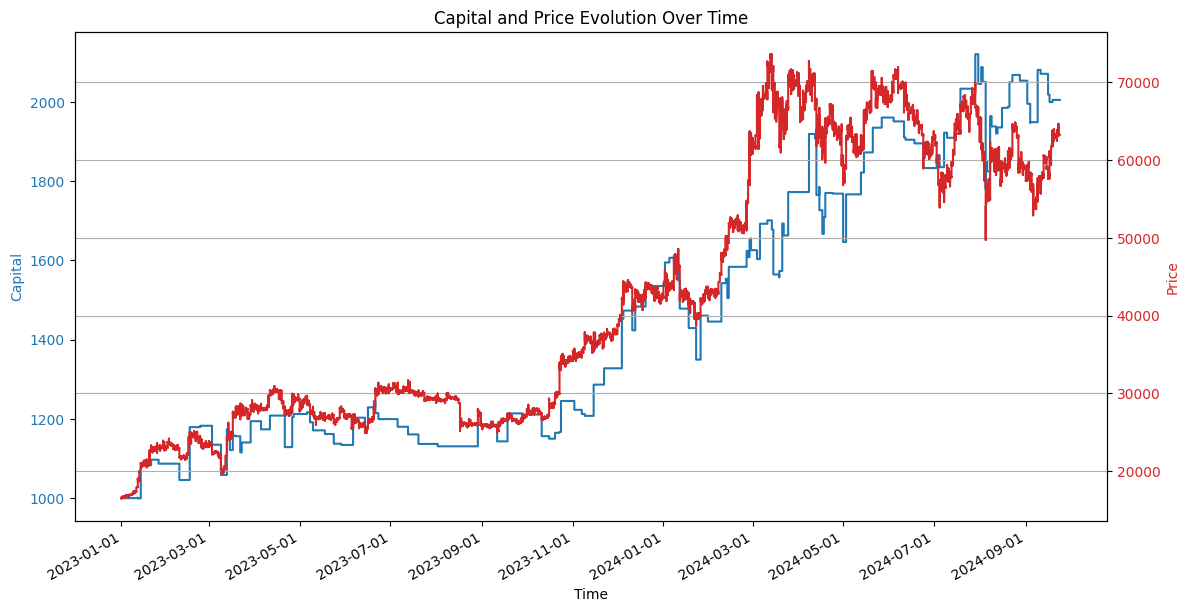

In [15]:
def compute_smoothed_ssti(close_prices, period=14, smoothing_period=14):
    """
    Computes a Smoothed Simple Slope Trend Indicator (SSTI).

    First, the raw SSTI is computed as the difference between the current close and the close from 'period' periods ago, divided by 'period'.
    Then, a rolling mean with window 'smoothing_period' is applied to reduce noise.
    
    Parameters:
        close_prices (pd.Series): Series of close prices.
        period (int): Lookback period for computing the raw slope.
        smoothing_period (int): Window size for smoothing the raw SSTI.
    
    Returns:
        pd.Series: The smoothed SSTI values.
    """
    raw_ssti = (close_prices - close_prices.shift(period)) / period/ close_prices
    smoothed_ssti = raw_ssti.rolling(window=smoothing_period, min_periods=1).mean()
    return smoothed_ssti

def dynamic_macd_trading_with_ssti(
    indicators, 
    fee=0.000, 
    initial_capital=1000, 
    macd_threshold=0.0, 
    ssti_threshold=0.1,  # example threshold for trend confirmation
    ssti_period=14,
    ssti_smoothing=5
):
    """
    Simulates an enhanced MACD trading strategy using a Smoothed SSTI for trend confirmation.
    
    The strategy enters a long position when the MACD histogram (macd_diff) exceeds the positive threshold
    and the smoothed SSTI indicates a trending market (its absolute value is above the specified threshold).
    It exits the position when the MACD histogram falls below the negative threshold and the smoothed SSTI confirms the trend.
    
    Parameters:
        indicators (pd.DataFrame): DataFrame with at least 'macd_diff' and 'close' columns.
        fee (float): Transaction fee as a fraction (default: 0.001 for 0.1% fee).
        initial_capital (float): Starting capital.
        macd_threshold (float): The threshold for the MACD histogram to trigger trades.
        ssti_threshold (float): Minimum absolute value of smoothed SSTI to consider the market trending.
        ssti_period (int): Lookback period to compute the raw SSTI.
        ssti_smoothing (int): Window size for smoothing the raw SSTI.
    
    Returns:
        trades (list): List of executed trades (each is a dict with trade details).
        capital_series (pd.Series): Series of capital values over time, using the same index as indicators.
    """
    # Compute the smoothed SSTI and add it to the indicators DataFrame.
    indicators['ssti'] = compute_smoothed_ssti(indicators['close'], period=ssti_period, smoothing_period=ssti_smoothing)
    
    in_position = False  # True if holding the asset
    capital = initial_capital
    position_size = 0    # Number of asset units purchased
    entry_capital = 0    # Capital allocated at entry
    trades = []          # List to record each trade
    capital_record = []  # Record capital evolution
    
    for i in range(len(indicators)):
        current_macd_diff = indicators['macd_diff'].iloc[i]
        current_ssti = indicators['ssti'].iloc[i]
        current_price = indicators['close'].iloc[i]
        
        # Confirm that the market is trending if the absolute smoothed SSTI is above the threshold.
        is_trending = abs(current_ssti) >= ssti_threshold
        
        # Buy signal: not in position, MACD histogram exceeds positive threshold, and market is trending.
        if not in_position and current_macd_diff > macd_threshold and is_trending:
            buy_price = current_price * (1 + fee)  # Fee increases the buying price
            position_size = capital / buy_price
            entry_capital = capital
            in_position = True
            trades.append({
                'type': 'buy',
                'price': buy_price,
                'index': indicators.index[i]
            })
        
        # Sell signal: in position, MACD histogram falls below negative threshold, and market is trending.
        elif in_position and current_macd_diff < -macd_threshold and is_trending:
            sell_price = current_price * (1 - fee)  # Fee decreases the selling price
            new_capital = position_size * sell_price
            profit = new_capital - entry_capital
            capital = new_capital
            in_position = False
            trades.append({
                'type': 'sell',
                'price': sell_price,
                'index': indicators.index[i],
                'profit': profit
            })
        
        capital_record.append(capital)
    
    # Close any remaining position at the end of the backtest
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        capital = new_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital  # Update the final capital record
    
    # Create a pandas Series for capital evolution using the same index as the indicators.
    capital_series = pd.Series(capital_record, index=indicators.index)
    
    return trades, capital_series

trades, capital_series = dynamic_macd_trading_with_ssti(indicators, macd_threshold=0.0, ssti_threshold=0.001, ssti_period=16, ssti_smoothing=16)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)


## Strategy 3: Dynamic RSI on sideways

Performance Metrics:
Total ROI (%): 133.7260567169738
Max Drawdown (%): 18.041508005188238
Sharpe Ratio: 0.008070048029073086
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 20.565617373769577
Trade Distribution: {'winning_trades': 114, 'losing_trades': 85, 'win_rate (%)': 57.286432160804026}
Profit Attribution: {'total_profit': 1337.260567169738, 'average_profit': 6.719902347586623, 'max_profit': 265.61669383759727, 'min_profit': -395.43434939018425}
Risk Reward Ratio: 1.1316940283389776
Total Trades: 199
Largest Win Trade (%): 265.61669383759727
Largest Lost Trade (%): -395.43434939018425
Sortino Ratio: -0.05449841716157586


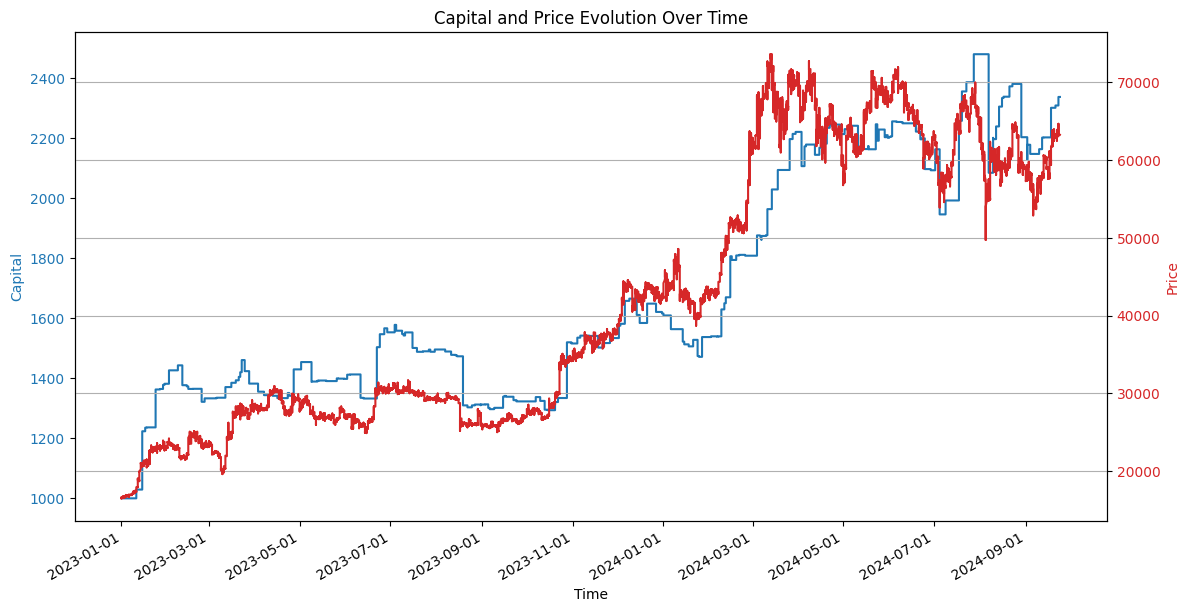

In [16]:
import pandas as pd
import numpy as np

def dynamic_rsi_sideways_trading_with_capital(
    indicators, 
    fee=0.001, 
    initial_capital=1000, 
    adx_threshold=25, 
    variance_factor=.5, 
    mae=0, 
    window=40
):
    """
    Simulates a dynamic RSI trading strategy that operates only during sideways markets.
    
    When the market is sideways (i.e., ADX is below adx_threshold), dynamic RSI thresholds 
    (overbought and oversold) are calculated based on the variance of the RSI over a rolling window.
    The strategy buys when the RSI falls below the dynamic oversold threshold (plus a margin adjustment)
    and sells when the RSI rises above the dynamic overbought threshold (minus a margin adjustment).
    No trades are executed when the market is trending (ADX >= adx_threshold).
    
    Parameters:
        indicators (pd.DataFrame): DataFrame with at least 'rsi', 'adx', and 'close' columns.
        fee (float): Transaction fee as a fraction (default: 0.001 for 0.1% fee).
        initial_capital (float): Starting capital.
        adx_threshold (float): ADX threshold below which the market is considered sideways (default: 25).
        variance_factor (float): Factor used to adjust dynamic RSI thresholds based on RSI variance.
        mae (float): Margin adjustment error to modify the dynamic RSI thresholds.
        window (int): Rolling window size for RSI variance calculation (default: 14).
    
    Returns:
        trades (list): List of executed trades (each is a dict with trade details).
        capital_series (pd.Series): Series of capital values over time, using the same index as indicators.
    """
    # Base RSI levels
    base_rsi_upper = 70
    base_rsi_lower = 30

    # Compute the rolling variance of the RSI; using sqrt of variance to scale thresholds
    rsi_std = indicators['rsi'].rolling(window=window, min_periods=1).std().bfill().ffill()
    rsi_mean = indicators['rsi'].rolling(window=window, min_periods=1).mean().bfill().ffill()
    # rsi_std = np.sqrt(rsi_variance)
    
    in_position = False   # True if holding the asset
    capital = initial_capital
    position_size = 0     # Number of asset units purchased
    entry_capital = 0     # Capital allocated at entry
    trades = []         # List to record each trade
    capital_record = [] # Record capital evolution
    
    for i in range(len(indicators)):
        current_rsi = indicators['rsi'].iloc[i]
        current_adx = indicators['adx'].iloc[i]
        current_price = indicators['close'].iloc[i]
        
        # Compute dynamic RSI thresholds using the standard deviation (sqrt(variance))
        dynamic_upper = rsi_mean.iloc[i] + variance_factor * rsi_std.iloc[i]
        dynamic_lower = rsi_mean.iloc[i] - variance_factor * rsi_std.iloc[i]
        # dynamic_upper = base_rsi_upper + variance_factor * rsi_std.iloc[i]
        # dynamic_lower = base_rsi_lower - variance_factor * rsi_std.iloc[i]
        
        # Trade only if the market is sideways
        if current_adx < adx_threshold:
            # Buy signal: not in position and RSI is sufficiently low relative to dynamic lower threshold
            if not in_position and current_rsi <= dynamic_lower + mae:
                buy_price = current_price * (1 + fee)  # Fee applied increases the buying price
                position_size = capital / buy_price
                entry_capital = capital
                in_position = True
                trades.append({
                    'type': 'buy',
                    'price': buy_price,
                    'index': indicators.index[i]
                })
            
            # Sell signal: in position and RSI is sufficiently high relative to dynamic upper threshold
            elif in_position and current_rsi >= dynamic_upper - mae:
                sell_price = current_price * (1 - fee)  # Fee applied decreases the selling price
                new_capital = position_size * sell_price
                profit = new_capital - entry_capital
                capital = new_capital
                in_position = False
                trades.append({
                    'type': 'sell',
                    'price': sell_price,
                    'index': indicators.index[i],
                    'profit': profit
                })
        
        # If the market is trending (ADX >= adx_threshold), no trading is done.
        # Capital remains unchanged.
        capital_record.append(capital)
    
    # If still in position at the end, close the position at the final price.
    if in_position:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        capital = new_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit
        })
        capital_record[-1] = capital  # Update the final capital record
    
    # Create a pandas Series for capital evolution using the same index as the indicators.
    capital_series = pd.Series(capital_record, index=indicators.index)
    
    return trades, capital_series
trades, capital_series = dynamic_rsi_sideways_trading_with_capital(indicators, adx_threshold=20, window= 23, variance_factor= 1.8, mae= 0)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)

- adx_threshold is around 20~25,
- window is around 20~30, usually the period in 15min timeframe
- variance factor is around 1.9~2.1

Here’s a detailed commentary on the RSI strategy’s performance metrics:

- **Total ROI (133.73%):**  
  The RSI strategy generates a high overall return, though slightly lower than the MACD strategy’s ROI. This suggests the strategy is profitable over the backtested period.

- **Max Drawdown (18.04%):**  
  A maximum drawdown of around 18% is considerably lower than that seen with the MACD strategy (28.64%). This implies that the RSI approach may be less volatile and offers better downside protection, which is important for risk management.

- **Sharpe Ratio (≈0.00807):**  
  Similar to the MACD strategy, the Sharpe ratio is very low. This indicates that when adjusted for risk (volatility), the returns aren’t particularly attractive. Both strategies may be generating returns in a way that doesn’t adequately compensate for the amount of risk taken.

- **Symbol ROI (282.88%):**  
  This value is identical for both strategies, indicating that the underlying asset’s performance is a major factor in the overall profitability, rather than the trading signal alone.

- **Trade Efficiency (20.57%):**  
  The RSI strategy’s trade efficiency is higher than the MACD strategy’s (~20.57% vs. ~15.83%). This means that, on average, each trade contributes a bit more to the overall profit, suggesting better risk/reward on a per-trade basis.

- **Trade Distribution and Win Rate:**  
  With 114 winning trades versus 85 losing trades, the win rate is about 57.29%, which is notably higher than the MACD strategy’s win rate (44.74%). A higher win rate is a positive sign, as it indicates that the RSI signals are more consistently capturing profitable moves.

- **Profit Attribution:**  
  The average profit per trade is around 6.72, which is slightly lower than the MACD strategy’s average profit (~7.47). However, the RSI strategy shows a smaller maximum profit but also a more contained minimum loss (max loss of around -395 vs. -218 for MACD). This could reflect that while the RSI strategy might not capture as huge winners as the MACD approach, it also limits losses better, contributing to its lower drawdown.

**Overall Comments:**  
The RSI strategy appears to offer a better risk profile than the MACD strategy, as evidenced by its lower maximum drawdown and higher win rate. Although both strategies deliver high ROI figures, the RSI method seems to provide more consistent and less volatile performance. However, the very low Sharpe ratios for both strategies suggest that while returns are high, they may not be adequately compensating for risk when considering volatility. This is a common issue discussed among traders, where high absolute returns may come with hidden risk levels that aren’t captured by simple return metrics.

In summary, while the RSI strategy’s overall ROI is slightly lower than the MACD strategy’s, its improved drawdown profile, higher win rate, and better trade efficiency make it potentially more attractive for risk-conscious traders. This balance between capturing profits and controlling losses is often key to long-term trading success.

## Strategy 4: Combined Strategy
- MACD in trending period
- RSI in sideway

Performance Metrics:
Total ROI (%): 57.99897706064184
Max Drawdown (%): 28.636068837554195
Sharpe Ratio: 0.004680995875794871
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 6.086980216612522
Trade Distribution: {'winning_trades': 193, 'losing_trades': 212, 'win_rate (%)': 47.654320987654316}
Profit Attribution: {'total_profit': 579.9897706064185, 'average_profit': 1.432073507670169, 'max_profit': 179.2389077891271, 'min_profit': -131.08131302876086}


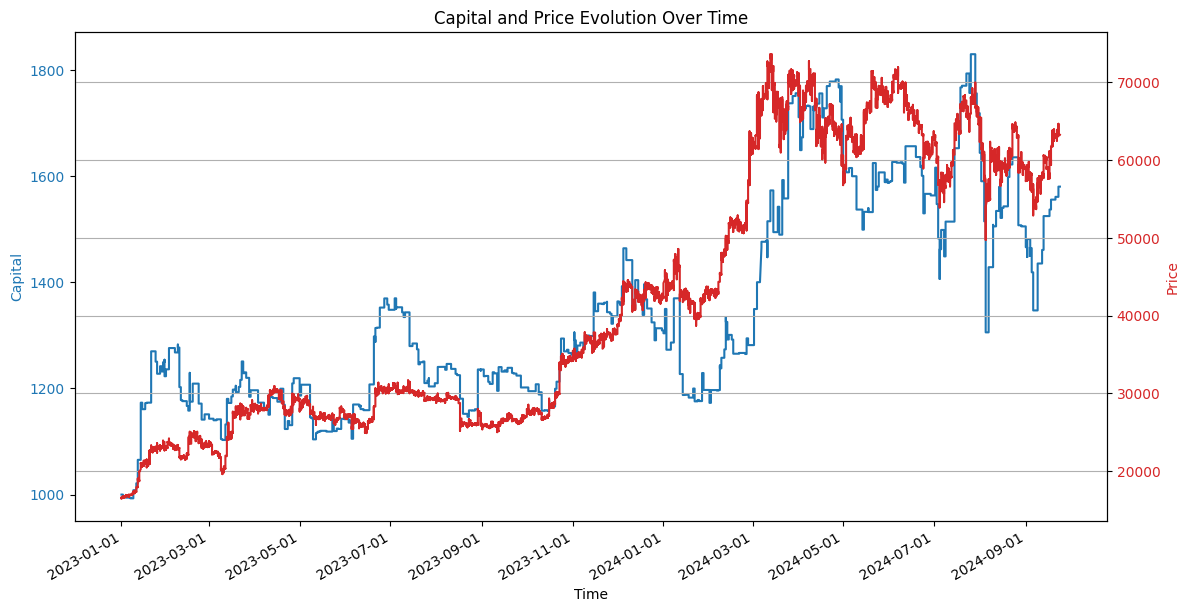

In [295]:
def combined_strategy_no_short(
    indicators, 
    fee=0.001, 
    initial_capital=1000, 
    rsi_trend_threshold=20,   # ADX below this triggers dynamic RSI strategy
    adx_macd_threshold=45,      # ADX above this triggers MACD histogram strategy
    variance_factor=1.0,
    rsi_variance_window=23     # Rolling window for RSI mean and std calculations
):
    """
    Combines two long-only strategies:
    
    1. Dynamic RSI Strategy (for non-trending conditions):
       When ADX < rsi_trend_threshold, the dynamic RSI boundaries are computed as:
           dynamic_upper = rsi_mean + 2 * variance_factor * rsi_std
           dynamic_lower = rsi_mean - 2 * variance_factor * rsi_std
       A long position is entered when RSI falls below the dynamic lower boundary and 
       exited when RSI crosses above the RSI mean.
       
    2. MACD Histogram Strategy (for trending conditions):
       When ADX > adx_macd_threshold, a long position is entered when the MACD histogram is positive 
       and exited when it turns negative.
    
    For ADX values between these thresholds, no new trades are initiated.
    
    The RSI rolling statistics are computed as:
        rsi_mean = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).mean().bfill().ffill()
        rsi_std = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).std().bfill().ffill()
    
    Parameters:
        indicators (pd.DataFrame): Must contain columns 'adx', 'rsi', 'macd_diff', and 'close'. 
                                   The DataFrame index should be a DateTimeIndex or similar.
        fee (float): Transaction fee as a fraction.
        initial_capital (float): Starting capital.
        rsi_trend_threshold (float): ADX level for dynamic RSI regime.
        adx_macd_threshold (float): ADX level for MACD regime.
        variance_factor (float): Scaling factor for RSI dynamic boundaries.
        rsi_variance_window (int): Rolling window to compute RSI mean and std (default: 20).
        
    Returns:
        trades (list): List of executed trades with details.
        capital_series (pd.Series): Series of capital values over time.
    """
    
    # Compute the RSI mean and standard deviation using the rolling window.
    indicators['rsi_mean'] = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).mean().bfill().ffill()
    indicators['rsi_std'] = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).std().bfill().ffill()
    
    trades = []
    capital_record = []
    capital = initial_capital
    position = None  # Only 'long' or None.
    entry_capital = 0
    position_size = 0
    
    for i in range(len(indicators)):
        adx = indicators['adx'].iloc[i]
        current_price = indicators['close'].iloc[i]
        current_index = indicators.index[i]
        
        # Determine regime based on ADX:
        # Use Dynamic RSI strategy when ADX < rsi_trend_threshold.
        if adx < rsi_trend_threshold:
            regime = 'RSI'
            current_rsi = indicators['rsi'].iloc[i]
            rsi_mean = indicators['rsi_mean'].iloc[i]
            rsi_std = indicators['rsi_std'].iloc[i]
            # Calculate dynamic boundaries.
            dynamic_upper = rsi_mean + variance_factor * rsi_std
            dynamic_lower = rsi_mean - variance_factor * rsi_std
            
            # Long entry: Buy when RSI is below the dynamic lower boundary.
            if position is None:
                if current_rsi < dynamic_lower:
                    buy_price = current_price * (1 + fee)
                    position_size = capital / buy_price
                    entry_capital = capital
                    position = 'long'
                    trades.append({
                        'type': 'buy',
                        'price': buy_price,
                        'index': current_index,
                        'regime': regime
                    })
            else:
                # Exit long when RSI reverts above the RSI mean.
                if position == 'long' and current_rsi > dynamic_upper:
                    sell_price = current_price * (1 - fee)
                    new_capital = position_size * sell_price
                    profit = new_capital - entry_capital
                    capital = new_capital
                    trades.append({
                        'type': 'sell',
                        'price': sell_price,
                        'index': current_index,
                        'profit': profit,
                        'regime': regime
                    })
                    position = None
        
        # Use MACD histogram strategy when ADX > adx_macd_threshold.
        elif adx > adx_macd_threshold:
            regime = 'MACD'
            current_macd_diff = indicators['macd_diff'].iloc[i]
            
            if position is None:
                if current_macd_diff > 0:
                    buy_price = current_price * (1 + fee)
                    position_size = capital / buy_price
                    entry_capital = capital
                    position = 'long'
                    trades.append({
                        'type': 'buy',
                        'price': buy_price,
                        'index': current_index,
                        'regime': regime
                    })
            else:
                if position == 'long' and current_macd_diff < 0:
                    sell_price = current_price * (1 - fee)
                    new_capital = position_size * sell_price
                    profit = new_capital - entry_capital
                    capital = new_capital
                    trades.append({
                        'type': 'sell',
                        'price': sell_price,
                        'index': current_index,
                        'profit': profit,
                        'regime': regime
                    })
                    position = None
        else:
            regime = 'None'
            # No new trade signals if ADX is between thresholds.
        
        capital_record.append(capital)
    
    # Close any open position at the end of the backtest.
    if position is not None:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit,
            'regime': regime
        })
        capital = new_capital
        capital_record[-1] = capital
    
    capital_series = pd.Series(capital_record, index=indicators.index)
    return trades, capital_series

trades, capital_series = combined_strategy_no_short(indicators, rsi_trend_threshold= 20, adx_macd_threshold= 45, variance_factor= 1.8, rsi_variance_window= 23)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)


Performance Metrics:
Total ROI (%): 5.286636953023958
Max Drawdown (%): 29.39466136308541
Sharpe Ratio: 0.001398102586845137
Symbol ROI (%): 282.882555147515
Trade Efficiency (%): 0.6425290645991608
Trade Distribution: {'winning_trades': 238, 'losing_trades': 269, 'win_rate (%)': 46.942800788954635}
Profit Attribution: {'total_profit': 52.86636953023958, 'average_profit': 0.10427291820560075, 'max_profit': 106.14105244455777, 'min_profit': -91.25675150524421}


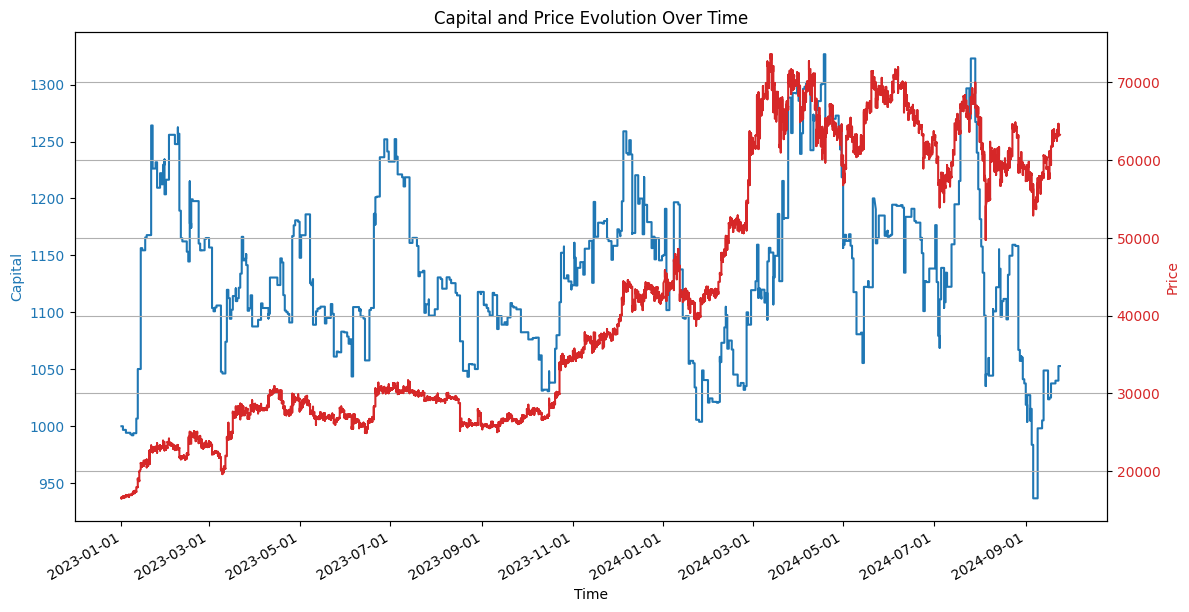

In [269]:
def combined_strategy_no_short_exit_on_downtrend_ssti(
    indicators, 
    fee=0.001, 
    initial_capital=1000, 
    rsi_trend_threshold=20,   # ADX below this triggers dynamic RSI regime
    adx_macd_threshold=45,      # ADX above this triggers MACD histogram regime
    variance_factor=1.0,
    rsi_variance_window=20,     # Rolling window for RSI mean and std calculations
    ssti_period=14,             # Lookback period for SSTI calculation
    ssti_smoothing=5            # Smoothing window for SSTI
):
    """
    Combines two long‑only strategies with an exit condition in the undefined ADX region,
    using the SSTI to determine the immediate trend.

    Available indicators (required in the DataFrame):
      'adx', 'rsi', 'macd_diff', and 'close'.
    Additionally, the function computes rolling RSI statistics and the SSTI from 'close'.

    Regimes:
      1. Dynamic RSI Strategy (when ADX < rsi_trend_threshold):
         - Compute dynamic RSI boundaries:
             dynamic_upper = rsi_mean + 2 * variance_factor * rsi_std
             dynamic_lower = rsi_mean - 2 * variance_factor * rsi_std
         - Enter a long position when RSI falls below the dynamic lower boundary.
         - Exit when RSI rises above the RSI mean.
      
      2. MACD Histogram Strategy (when ADX > adx_macd_threshold):
         - Enter a long position when the MACD histogram ('macd_diff') is positive.
         - Exit when the MACD histogram turns negative.
      
      3. Undefined Region (when rsi_trend_threshold <= ADX <= adx_macd_threshold):
         - Compute the smoothed SSTI from 'close'. If the SSTI is negative (downtrend), exit any open position.
         - Otherwise, hold the position.
    
    Rolling RSI statistics are computed as:
        rsi_mean = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).mean().bfill().ffill()
        rsi_std  = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).std().bfill().ffill()
    
    Parameters:
      indicators (pd.DataFrame): Must contain columns:
          'adx', 'rsi', 'macd_diff', and 'close'
          (The DataFrame should be indexed by time.)
      fee (float): Transaction fee as a fraction.
      initial_capital (float): Starting capital.
      rsi_trend_threshold (float): ADX level for the dynamic RSI regime.
      adx_macd_threshold (float): ADX level for the MACD regime.
      variance_factor (float): Scaling factor for RSI dynamic boundaries.
      rsi_variance_window (int): Rolling window for computing RSI mean and std.
      ssti_period (int): Lookback period for computing the raw SSTI.
      ssti_smoothing (int): Window size for smoothing the SSTI.
      
    Returns:
      trades (list): List of executed trades with details.
      capital_series (pd.Series): Series of capital values over time.
    """
    
    # Compute the RSI rolling mean and standard deviation.
    indicators['rsi_mean'] = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).mean().bfill().ffill()
    indicators['rsi_std'] = indicators['rsi'].rolling(window=rsi_variance_window, min_periods=1).std().bfill().ffill()
    
    # Compute the smoothed SSTI and add it to the DataFrame.
    indicators['ssti'] = compute_smoothed_ssti(indicators['close'], period=ssti_period, smoothing_period=ssti_smoothing)
    
    trades = []
    capital_record = []
    capital = initial_capital
    position = None  # Only 'long' or None.
    entry_capital = 0
    position_size = 0
    
    for i in range(len(indicators)):
        adx = indicators['adx'].iloc[i]
        current_price = indicators['close'].iloc[i]
        current_index = indicators.index[i]
        
        # Determine the current regime based on ADX.
        if adx < rsi_trend_threshold:
            regime = 'RSI'
        elif adx > adx_macd_threshold:
            regime = 'MACD'
        else:
            regime = 'Undefined'
        
        # In the Undefined region, use the smoothed SSTI to decide exit:
        if regime == 'Undefined':
            current_ssti = indicators['ssti'].iloc[i]
            if position is not None:
                # If SSTI is negative (indicating downward momentum), exit the position.
                if current_ssti < -0.001:
                    sell_price = current_price * (1 - fee)
                    new_capital = position_size * sell_price
                    profit = new_capital - entry_capital
                    trades.append({
                        'type': 'sell',
                        'price': sell_price,
                        'index': current_index,
                        'profit': profit,
                        'regime': regime
                    })
                    capital = new_capital
                    position = None
            # If no position is open in the Undefined region, do nothing.
        
        # Dynamic RSI Strategy when ADX < rsi_trend_threshold.
        elif regime == 'RSI':
            current_rsi = indicators['rsi'].iloc[i]
            rsi_mean = indicators['rsi_mean'].iloc[i]
            rsi_std = indicators['rsi_std'].iloc[i]
            dynamic_lower = rsi_mean - variance_factor * rsi_std
            dynamic_upper = rsi_mean + variance_factor * rsi_std
            if position is None:
                # Enter a long position when RSI falls below the dynamic lower boundary.
                if current_rsi < dynamic_lower:
                    buy_price = current_price * (1 + fee)
                    position_size = capital / buy_price
                    entry_capital = capital
                    position = 'long'
                    trades.append({
                        'type': 'buy',
                        'price': buy_price,
                        'index': current_index,
                        'regime': regime
                    })
            else:
                # Exit the long position when RSI reverts above its mean.
                if position == 'long' and current_rsi > dynamic_upper:
                    sell_price = current_price * (1 - fee)
                    new_capital = position_size * sell_price
                    profit = new_capital - entry_capital
                    trades.append({
                        'type': 'sell',
                        'price': sell_price,
                        'index': current_index,
                        'profit': profit,
                        'regime': regime
                    })
                    capital = new_capital
                    position = None
        
        # MACD Histogram Strategy when ADX > adx_macd_threshold.
        elif regime == 'MACD':
            
            current_macd_diff = indicators['macd_diff'].iloc[i]
            if position is None:
                # Enter a long position when MACD histogram is positive.
                if current_macd_diff > 0:
                    buy_price = current_price * (1 + fee)
                    position_size = capital / buy_price
                    entry_capital = capital
                    position = 'long'
                    trades.append({
                        'type': 'buy',
                        'price': buy_price,
                        'index': current_index,
                        'regime': regime
                    })
            else:
                # Exit the long position when MACD histogram turns negative.
                if position == 'long' and current_macd_diff < 0:
                    sell_price = current_price * (1 - fee)
                    new_capital = position_size * sell_price
                    profit = new_capital - entry_capital
                    trades.append({
                        'type': 'sell',
                        'price': sell_price,
                        'index': current_index,
                        'profit': profit,
                        'regime': regime
                    })
                    capital = new_capital
                    position = None
        
        capital_record.append(capital)
    
    # Close any open position at the end of the backtest.
    if position is not None:
        final_price = indicators['close'].iloc[-1] * (1 - fee)
        new_capital = position_size * final_price
        profit = new_capital - entry_capital
        trades.append({
            'type': 'sell',
            'price': final_price,
            'index': indicators.index[-1],
            'profit': profit,
            'regime': regime
        })
        capital = new_capital
        capital_record[-1] = capital
    
    capital_series = pd.Series(capital_record, index=indicators.index)
    return trades, capital_series

trades, capital_series = combined_strategy_no_short_exit_on_downtrend_ssti(indicators, rsi_trend_threshold= 23, adx_macd_threshold= 45, variance_factor= 1.8, rsi_variance_window= 23, ssti_period= 16, ssti_smoothing= 16)
performance = compute_performance_metrics(trades, capital_series, indicators)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators, capital_series)

## Seems like their combination is not neccessarily better...
- Weird, but understandable
- Signal Conflicts and Lag:
When you try to switch between strategies (e.g., using RSI in one regime and MACD in another), the conditions to determine the regime (such as ADX thresholds) can be ambiguous. This can lead to conflicting signals or delays in entering/exiting trades, which might cancel out the benefits of each standalone strategy.

- Overfitting and Parameter Sensitivity:
Adding more conditions and thresholds increases the number of parameters you need to optimize. This extra complexity often leads to overfitting on historical data, where the strategy appears to work well but fails to generalize in live trading.

- Increased Transaction Costs:
Frequent switching between strategies may increase the number of trades. Each trade comes with fees and potential slippage, which can erode profits, especially if the added rules cause you to enter or exit positions more often.

- Market Noise and Regime Misclassification:
The market rarely fits neatly into a single regime. The indicators used to define these regimes (like ADX) can be noisy, leading to misclassification. When the regime isn't clear, the extra logic (such as using the SSTI to exit) might cause premature exits or missed opportunities.

## Now test in the untouched data

In [296]:
datahandler_2 = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '15m', '2024-09-24', '2025-03-01'
datahandler_2.load_data(inter, begin, end)
BTC_indicator_2 = SingleSymbolFeatureExtractor('BTCUSDT', datahandler_2)
BTC_indicator_2.load_full_range()
indicators_2 = BTC_indicator_2.indicators
datahandler_2.cleaned_data['close'] = datahandler_2.cleaned_data['close']
indicators_2 = pd.concat([indicators_2,datahandler_2.cleaned_data[['close', 'volume']]],axis= 1)

Performance Metrics:
Total ROI (%): -23.3163899263807
Max Drawdown (%): 29.378959694845747
Sharpe Ratio: -0.010491311389408236
Symbol ROI (%): 33.64435037698302
Trade Efficiency (%): -29.97903330266687
Trade Distribution: {'winning_trades': 14, 'losing_trades': 24, 'win_rate (%)': 36.84210526315789}
Profit Attribution: {'total_profit': -233.16389926380702, 'average_profit': -6.135892085889658, 'max_profit': 50.695437906512666, 'min_profit': -57.47486630402409}


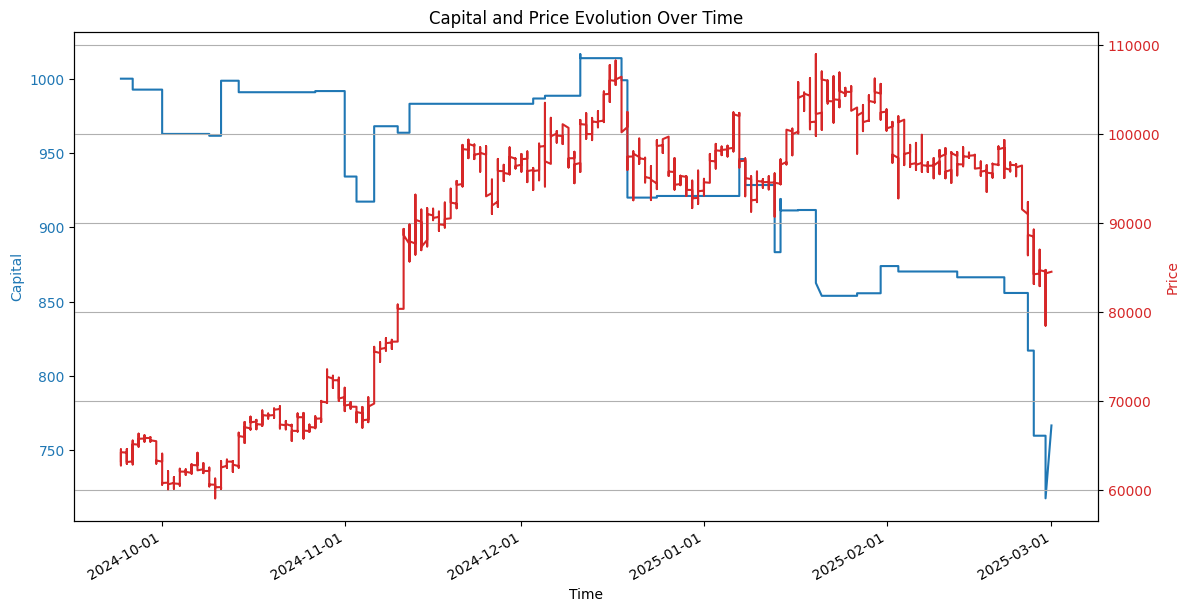

In [301]:
trades, capital_series = dynamic_macd_trading_with_trend_confirmation(indicators_2, macd_threshold=0,adx_threshold=45)
performance = compute_performance_metrics(trades, capital_series, indicators_2)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators_2, capital_series)

Performance Metrics:
Total ROI (%): 14.552402057378073
Max Drawdown (%): 11.990131835430697
Sharpe Ratio: 0.006659745110770907
Symbol ROI (%): 33.64435037698302
Trade Efficiency (%): 14.86894125397897
Trade Distribution: {'winning_trades': 30, 'losing_trades': 21, 'win_rate (%)': 58.82352941176471}
Profit Attribution: {'total_profit': 145.52402057378072, 'average_profit': 2.8534121681133473, 'max_profit': 72.66681835633574, 'min_profit': -68.38836205578787}


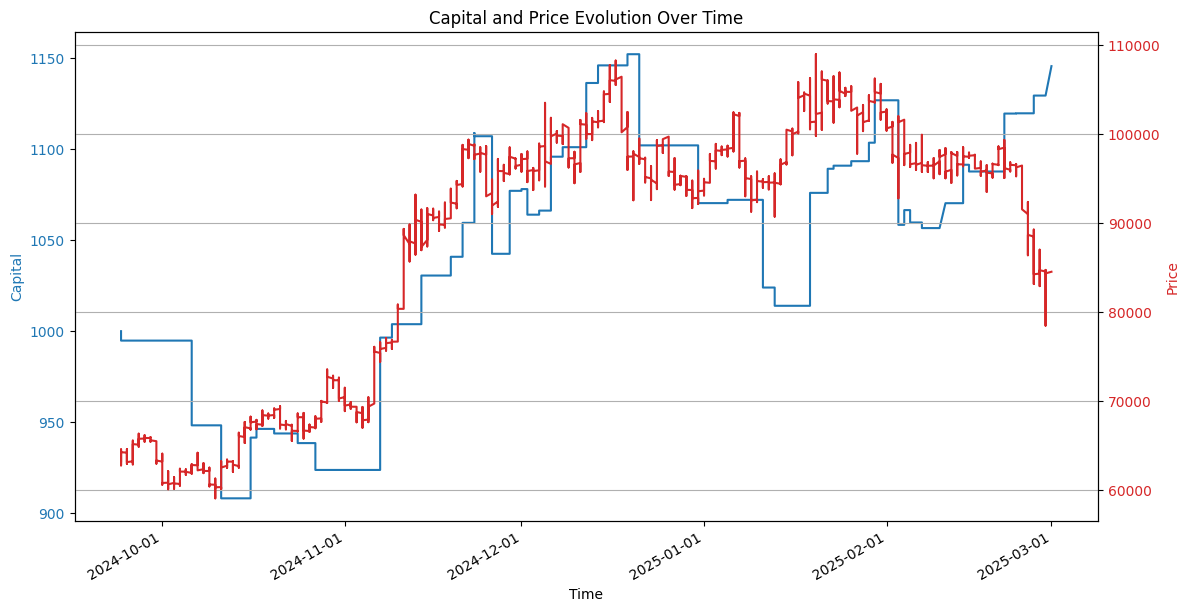

In [311]:
trades, capital_series = dynamic_rsi_sideways_trading_with_capital(indicators_2, adx_threshold=22, window= 23, variance_factor= 1.8, mae= 0)
performance = compute_performance_metrics(trades, capital_series, indicators_2)
print("Performance Metrics:")
for key, value in performance.items():
    print(f"{key}: {value}")

# plot_capital(capital_series)
plot_price_and_capital(indicators_2, capital_series)

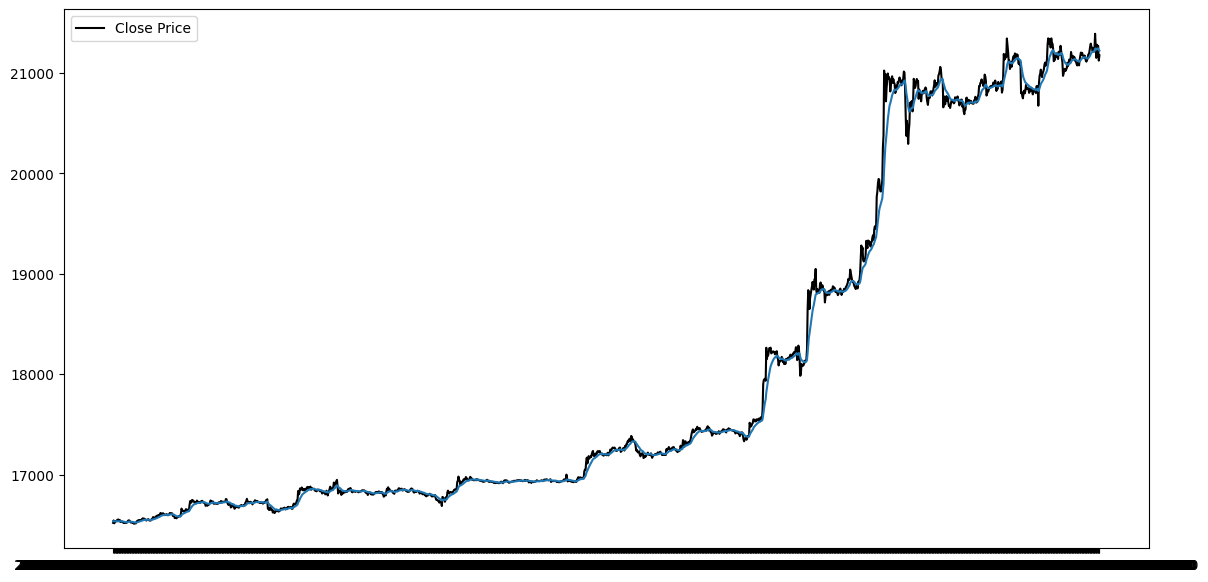

In [324]:

toplot = indicators.head(1600)
plt.figure(figsize=(14, 7))
plt.plot(toplot.index, toplot['close'], label='Close Price', color='black')
plt.plot(toplot.index, toplot['ema'])
plt.legend()
plt.show()

